# Stock Price Prediction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels
import pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

## Stock Price Data Exploring
$\textbf{Shanghai Composite Index}$ is the most important index in Chinese stock market. The value of this index is a comprehensive reflection of the whole stock market in China. Shanghai Composite Index is like the barometer for Chinese stock market. So it is necessary to do research on this index, this could support investers to make investing decisions. 

In [2]:
df = pd.read_csv("./data/sh000001.csv")

df.index = [datetime.fromisoformat(date) for date in df["date"]]

close_price = df["close"]

close_price = close_price[250:380]
test = df["close"][380:390]
close_price

2017-04-27    3152.187
2017-04-28    3154.658
2017-05-02    3143.712
2017-05-03    3135.346
2017-05-04    3127.369
                ...   
2017-10-31    3393.342
2017-11-01    3395.913
2017-11-02    3383.310
2017-11-03    3371.744
2017-11-06    3388.174
Name: close, Length: 130, dtype: float64

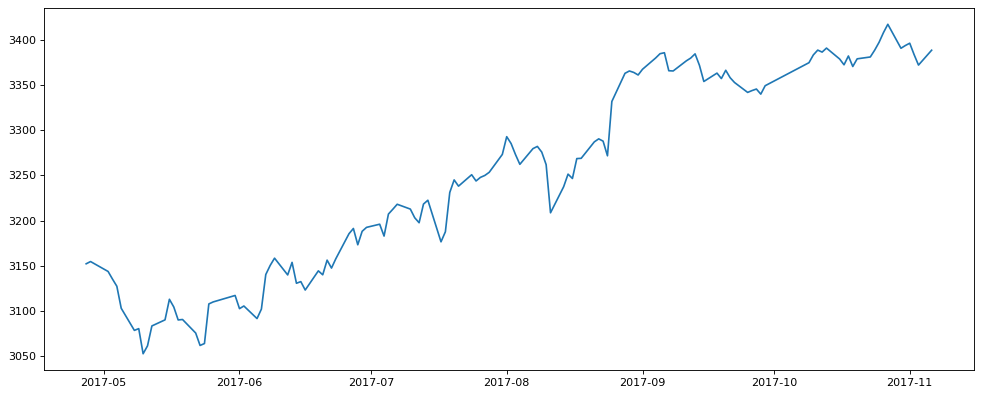

In [3]:
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)
plt.plot(close_price)

### Stock Price Differentation and ADF Test

In [4]:
def adf_test(time_series):
    test = adfuller(time_series, autolag='AIC')
    
    print("=========================================")
    print("adf", test[0])
    print("p value", test[1])
    print("number of observation used", test[3])
    for item in test[4].items():
        print("critical value %s: =%s" % (item[0], item[1]))
    print("=========================================")


In [5]:
adf_test(close_price)

adf -0.4965119394765454
p value 0.8926953727592885
number of observation used 126
critical value 1%: =-3.4833462346078936
critical value 5%: =-2.8847655969877666
critical value 10%: =-2.5791564575459813


From the graph above, we could find that this index is $\textbf{unstable}$ and there is a obivious trend in this time series. Based on the $\textbf{adf test}$. the adf value is bigger than three critical values and p value is really big. So our first step is to clean this trend and make this time series stable. So we did $\textbf{first difference}$ to the time series and did the adf test again. The adf value is smaller than the three critical values also p value is close to 0. So we could say that this time series is $\textbf{stable}$. 

adf -7.528198912244678
p value 3.637112660821248e-11
number of observation used 126
critical value 1%: =-3.4833462346078936
critical value 5%: =-2.8847655969877666
critical value 10%: =-2.5791564575459813


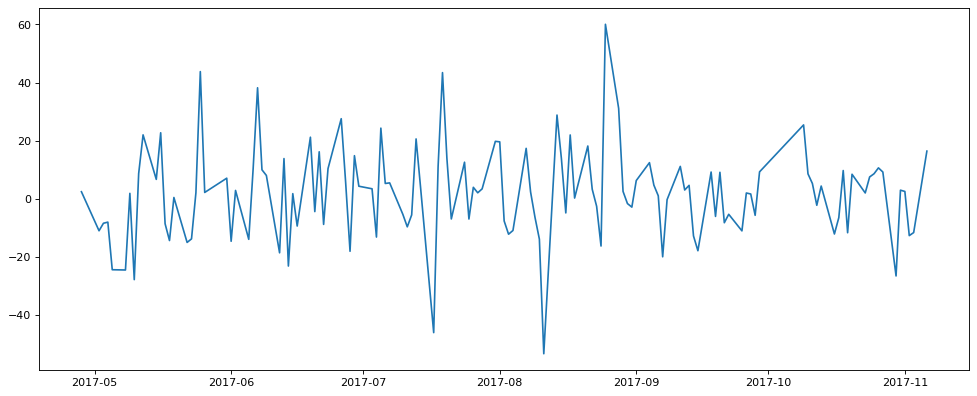

In [6]:
# Apply First Difference
diff = close_price.diff()[1:]

figure(figsize=(15, 6), dpi=80)
plt.plot(diff)

adf_test(diff)

## Stock Price Based ARMA
At first we did a model based on stock price. $\textbf{ARMA}$ model is a widely used stochastic time serises model. Also it only need one input, which is perfect since we only consider stock price now . 

### Find P and Q Parameter of ARMA
For ARMA model we need to find the parameter. At first we observe the $\textbf{autocorrletaion}$ and $\textbf{partial autocorrletaion}$ to find the p and q value, which is p = 2 and q = 1. 

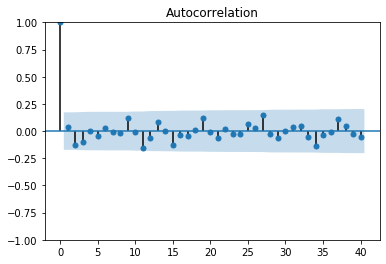

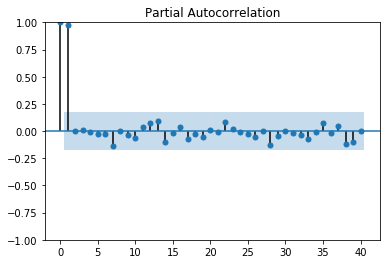

In [7]:
output_acf = plot_acf(diff, lags = 40)
output_pacf = plot_pacf(close_price, lags = 40, method="ywm")

### Model Fitting

In [8]:
model = ARIMA(endog=close_price, order=(2, 0, 1)).fit()
model.summary()

/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  130
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -547.055
Date:                Thu, 28 Apr 2022   AIC                           1104.110
Time:                        20:11:21   BIC                           1118.447
Sample:                             0   HQIC                          1109.936
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3249.5210     95.809     33.917      0.000    3061.738    3437.304
ar.L1          0.6928      1.301      0.533      0.594      -1.856       3.242
ar.L2          0.2927      1.291      0.227      0.821      -2.238       2.824
ma.L1          0.3714      1.264      0.294      0.769      -2.105       2.848
sigma2       256.7615     24.033     10.683      0.000     209.657     303.866
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                19.05
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
def r_mse(y_true, y_predict):
    assert len(y_true) == len(y_predict), "Length is not equal"

    rmse = 0
    for i in range(len(y_true)):
        temp = (y_true[i] - y_predict[i])**2
        rmse += temp
    rmse /= len(y_true)
    
    return rmse**0.5
        

### $$RMSE=\sqrt{\frac{\sum^n_{i=1}(Y_{pre,i}-Y_{true,i})^2}{n}}$$

16.040416800491233


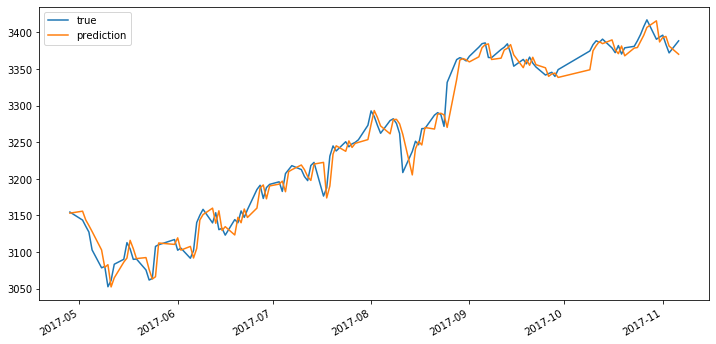

In [10]:
close_price[1:].plot(figsize=(12, 6), label="true")
model.predict()[1:].plot(label="prediction")
plt.legend()

rmse = r_mse(close_price[1:], model.predict()[1:])
print(rmse)

### Result Analysis
Above is the raw stock price and the predctions graph. We use $\textbf{RMSE}$ to evaluate our prediction. WE find the rmse is 16, it is not ideal. Also, the $\textbf{AIC}$ is hall, means this model is  $\textbf{unstable}$. We think the $\textbf{limit}$ of the model above is it only consider the stock price which is the technical field this is only what happen inside the stock market. Since the stock market are inflenced by many outside events. We want some index that could represent a comprehensive reflection of many exogenous variables of the stock market, a index that could reflext macroeconomics, company fundamental information, plicies and major events in the world. 

## BI value
Because of the internet media developing, people tends to communicate through websites. At stock market, people likes to share and discuss their thinking for a stock on real time stock review. we think real time stock review contains abundant finance information and it could be seen as a comprehensive reflection of the exogenous vairables outside the stock market. So we want to add this to our model to seek a better performance. Below is the  $\textbf{BI equation}$
### $$BI=ln(\frac{1+M^{bull}}{1+M^{bear}})$$

In [11]:
BI_data = pd.read_csv("./generated_data/bi_idx.csv")
BI_data.index = [datetime.fromisoformat(date) for date in BI_data["created_time"]]

BI = BI_data["BI"][close_price.index][1:] / 100
BI_test  = BI_data["BI"][test.index] / 100


### Find Relationship Between Stock Price and BI
First, we want to find out if the stpock price and BI index are related. So we use $\textbf{pearson corrlation coefficient}$ to evalute the relationship.
### $$r = \frac{\sum(x_i-\overline{x})(y_i-\overline{y})}{\sqrt{\sum(x_i-\overline{x})^2\sum(y_i-\overline{y})^2}} $$
We get the value of 0.58, which proves that they are related. So BI index reflext the stock price in some way.

In [12]:
def stock_price_change(previous_price, current_price):
    return (current_price - previous_price) / previous_price

Pearson Corrlation Coefficient: 0.5794505359849492


<Figure size 1200x480 with 0 Axes>

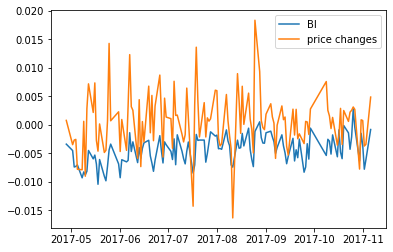

<Figure size 1200x480 with 0 Axes>

In [13]:
price_changes = [stock_price_change(close_price[i], close_price[i+1]) for i in range(len(close_price)-1)]
corr = np.corrcoef(price_changes, BI)[0][1]
print("Pearson Corrlation Coefficient:", (corr))

plt.plot(BI.index, BI, label="BI")
plt.plot(BI.index, price_changes, label="price changes")
plt.legend()
figure(figsize=(15, 6), dpi=80)
                 
                                    

## Use BI as Exog to Build ARIMA
We build a  $\textbf{ARIMA}$ model and use BI as the exog time series. ARIMA is a upgrade from ARMA and it could take a time series as the  $\textbf{outside exog}$, which is really suit our demand. 
### Model Fitting

In [14]:
model = ARIMA(endog=price_changes, 
              exog=BI, 
              order=(2, 1, 1)).fit()
model.summary()

/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 522.768
Date:                Thu, 28 Apr 2022   AIC                          -1035.535
Time:                        20:11:23   BIC                          -1021.275
Sample:                             0   HQIC                         -1029.741
                                - 129                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BI             1.4720      0.151      9.764      0.000       1.177       1.767
ar.L1          0.0584      0.110      0.534      0.594      -0.156       0.273
ar.L2          0.0474      0.086      0.551      0.582      -0.121       0.216
ma.L1         -0.9689      0.025    -38.417      0.000      -1.018      -0.919
sigma2      1.622e-05   1.84e-06      8.834      0.000    1.26e-05    1.98e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.58
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               0.62   Skew:                             0.41
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
def inverse_difference(last_ob, value):
    return (1 + value) * last_ob

12.58499521526127


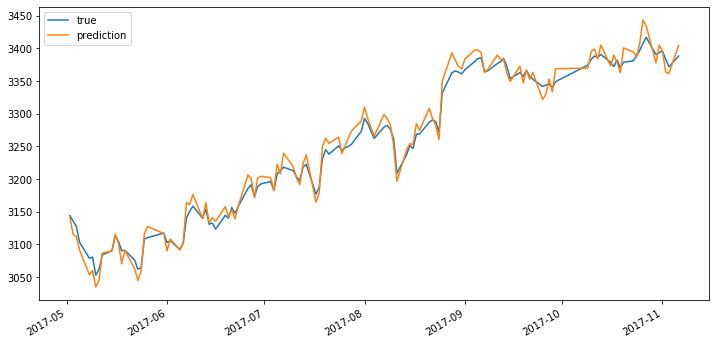

In [16]:
close_price[2:].plot(figsize=(12, 6), label="true")

plt.plot(close_price[2:].index, 
        [inverse_difference(close_price[2:][i], model.predict()[1:][i]) for i in range(len(close_price[2:]))], label="prediction")
plt.legend()

rmse = r_mse(close_price[2:], [inverse_difference(close_price[2:][i], model.predict()[1:][i]) for i in range(len(close_price[2:]))])
print(rmse)

### Result Analysis
Based on the summary above, the AIC is really $\textbf{small}$, means the model is stable. The std error is small and the $P>|Z|$ 1 is close to 0 means the $\textbf{satistical significance}$ of this model is high， so we coud rely on this model's prediction.

### Exploring the Result
Predict the actual stock price is hard. So we would like to transform the result of the model prediction to classification so we could predict the stocck price's tending in a short term.


In [17]:
predictions = [inverse_difference(close_price[2:][i], model.predict()[1:][i]) for i in range(len(close_price[2:]))]
predictions

[3140.96400396062,
 3115.181617453674,
 3111.7866199308096,
 3091.286955318655,
 3053.3609020816657,
 3059.8737657548577,
 3034.7000964549256,
 3044.628494264145,
 3086.5307660105877,
 3089.8975624858513,
 3115.629611948827,
 3101.9645804162883,
 3070.280098881678,
 3090.389196164937,
 3062.4332604063084,
 3044.6853804513066,
 3058.6638499477313,
 3116.4241076854655,
 3127.298155828456,
 3116.325774998929,
 3090.1415772227697,
 3107.754730481387,
 3091.841982335161,
 3102.0628322294892,
 3163.86453022618,
 3160.813182542758,
 3176.2286854553067,
 3139.1433689314426,
 3163.453575189259,
 3132.5517447993043,
 3140.6230468513,
 3135.1816775554316,
 3157.570478893736,
 3141.7903922589303,
 3152.583400701166,
 3138.7411022144015,
 3158.342481720541,
 3206.209328679525,
 3200.087004647489,
 3171.301460067029,
 3201.6691831537755,
 3204.012769285949,
 3202.0293347454567,
 3181.9711210324203,
 3222.6186704318834,
 3207.565402252626,
 3239.374115930351,
 3218.4377474287166,
 3201.3970792324017,

#### Static Prediction
First we will use model to predict 9 future days. The result shows that , the first day is good, but after 11.9 the tending is wrong. We can see that this only get a little bit than half correct. 

In [18]:
def static_predict(model, true, exog, start_date, predict_days=10):
    

    
    prediction =  np.array(model.predict(start=start_date, end=start_date+predict_days, exog=exog))
    
    count = 0
    for i in range(predict_days-1):
        true_value = true[i+1]
        predict = prediction[i+1]
        
        print("Date:", true.index[i+1], "predict:", predict, "index value:", true_value, 
              "actual:", "rise" if true_value >= true[i] else "fall",
              "predict:", "rise" if predict >= prediction[i] else "fall")
        true_trend = "rise" if true_value >= true[i] else "fall"
        predict_trend = "rise" if predict >= prediction[i] else "fall"
        count = count + 1 if true_trend == predict_trend else count

    print(count * 100 / (predict_days-1), "% trend predict correct")
    print("=======================================================================")
        
        
    

In [19]:
static_predict(model, test, BI_test, 128, predict_days=10)

Date: 2017-11-08 00:00:00 predict: 0.005885118438968278 index value: 3415.46 actual: rise predict: rise
Date: 2017-11-09 00:00:00 predict: 0.005749758826181818 index value: 3427.795 actual: rise predict: fall
Date: 2017-11-10 00:00:00 predict: 0.007250829007628601 index value: 3432.673 actual: rise predict: rise
Date: 2017-11-13 00:00:00 predict: 0.0022770793592997145 index value: 3447.836 actual: rise predict: fall
Date: 2017-11-14 00:00:00 predict: 7.745987966159724e-05 index value: 3429.548 actual: fall predict: fall
Date: 2017-11-15 00:00:00 predict: -0.00293483470306325 index value: 3402.525 actual: fall predict: fall
Date: 2017-11-16 00:00:00 predict: -0.0050022250781363 index value: 3399.25 actual: fall predict: fall
Date: 2017-11-17 00:00:00 predict: -0.00124822236593616 index value: 3382.908 actual: fall predict: rise
Date: 2017-11-20 00:00:00 predict: -0.005025385080692675 index value: 3392.3990000000003 actual: rise predict: fall
55.55555555555556 % trend predict correct


/Users/hujiaming/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


#### Rolling Prediction
Since the prediction in the first day is correct. So we try to add the predited day's value in the model and retrain the model to predict new day. We get $77.78\%$ $\textbf{tend prediction}$ correct.This is a big improvement. ALso we could find that our model trying to predict fall when the actual is raising, which is a conservative invester.

In [20]:
def roll_predict(train, BI_train, true, exog, predict_days=10):
    
    dates = true.index
    train = np.array(train.copy())
    BI_train = np.array(BI_train.copy())
    true = np.array(true.copy())
    exog = np.array(exog.copy())
    prediction = []
    
    for i in range(predict_days):
        
        model = ARIMA(endog=train, 
              exog=BI_train, 
              order=(2, 1, 1)).fit()
        prediction.append(model.forecast(exog=exog[i])[0])
        
        train = np.append(train, true[i])
        BI_train = np.append(BI_train, exog[i])
        
    count = 0
    for i in range(predict_days-1):
        true_value = true[i+1]
        predict = prediction[i+1]
        print("Date:", dates[i+1], "predict:", predict, "index value:", true_value, 
              "actual:", "rise" if true_value >= true[i] else "fall",
              "predict:", "rise" if predict >= prediction[i] else "fall")
        true_trend = "rise" if true_value >= true[i] else "fall"
        predict_trend = "rise" if predict >= prediction[i] else "fall"
        count = count + 1 if true_trend == predict_trend else count

    print(count * 100 / (predict_days-1), "% trend predict correct")
    print("=======================================================================")  
        

In [21]:
roll_predict(close_price[1:], BI, test, BI_test)

Date: 2017-11-08 00:00:00 predict: 3415.6740106256316 index value: 3415.46 actual: rise predict: rise
Date: 2017-11-09 00:00:00 predict: 3416.7416358252412 index value: 3427.795 actual: rise predict: rise
Date: 2017-11-10 00:00:00 predict: 3417.3563132946647 index value: 3432.673 actual: rise predict: rise
Date: 2017-11-13 00:00:00 predict: 3428.4797980540366 index value: 3447.836 actual: rise predict: rise
Date: 2017-11-14 00:00:00 predict: 3442.339691245832 index value: 3429.548 actual: fall predict: rise
Date: 2017-11-15 00:00:00 predict: 3422.021848751084 index value: 3402.525 actual: fall predict: fall
Date: 2017-11-16 00:00:00 predict: 3408.0787945422653 index value: 3399.25 actual: fall predict: fall
Date: 2017-11-17 00:00:00 predict: 3392.5638216836605 index value: 3382.908 actual: fall predict: fall
Date: 2017-11-20 00:00:00 predict: 3387.213245734168 index value: 3392.3990000000003 actual: rise predict: fall
77.77777777777777 % trend predict correct


#### Backtest
Below is a simple back test we did to test if we could make money based on our predictions. The $\textbf{strategy}$ of this back test model is use all investment to buy the index if we predict that there is a rise tomorrow and we will sell all the shares if we predict there is a fall tomorrow. Becuase our model like to predict fall when actually a rise not like to predict rise when there is actual fall, so we think this is a safe strategy, even though we will miss some chance for profit but we have low risk to loss money. The $\textbf{Control group}$'s strategy is buying all the shares from day one, hold and sell all the shares at the last day. From the result we can see that our strategy beat the control group and make 15k more. And the total profit rate of our model is around 20%. We think this is a great outcome. 

In [22]:
inital_investment = investment  = 100000
shares = 0
for true_pre, pred in zip(close_price[:-1], predictions):
    if pred > true_pre:
        shares = shares + investment // true_pre
        investment = investment - investment // true_pre * true_pre
    elif pred < true_pre:
        investment = investment + shares * true_pre
        shares = 0 
#     print(investment, shares)
print("Start:", close_price.index[1], "End:", close_price.index[-1],
    "\nFinal investment: $", investment + shares * close_price[-1], 
      "\nControl group: $", inital_investment // close_price[0] * close_price[-1],
      "\nExcess return: $", investment + shares * close_price[-1] - inital_investment // close_price[0] * close_price[-1],
     "\nTotal profit rate: ", (investment + shares * close_price[-1] - inital_investment) * 100 / inital_investment, "%")    

Start: 2017-04-28 00:00:00 End: 2017-11-06 00:00:00 
Final investment: $ 119800.11400000002 
Control group: $ 105033.39400000001 
Excess return: $ 14766.720000000001 
Total profit rate:  19.800114000000015 %
